# Imports

Import necessary libraries and modules including:
| Libraries | Version | Channel |
| ----------- | ----------- | ----------- |
| Matplotlib | 3.9.1 | conda-forge |
| NumPy | 2.2.2 | conda-forge |
| Matplotlib | 3.9.1 | conda-forge |
| Pandas | 2.2.3 | conda-forge |
| Pillow | 9.4.0 | conda-forge |
| Pytorch | 2.5.1 | conda-forge |
| Seaborn | 0.13.2 | conda-forge |
| Sklearn | 1.6.1 | conda-forge |

In [59]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as transforms

from PIL import Image
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR


# Variables

For the sake of simpleness, the essentail constants are listed down below.

In [60]:
# Torch seed (for reproducibility purpose)
SEED = 33

In [61]:
# Dataset paths
dataset_path = "cropped_faces_dataset"

train_dir_fake = os.path.join(dataset_path, "AI")
train_dir_real = os.path.join(dataset_path, "human")

In [62]:
# Training varaibles
BATCH_SIZE = 64 # Number of images per batch
EPOCH = 50 # Epoch size
TRAIN_SIZE = 0.95 # 90 % of the training data is used for model training
VAL_SIZE = 0.05 # 10 % of the training data is used for model validation
LEARNING_RATE = 0.0001 # Model's learning rate (default = 0.001)
NUM_WORKERS = 12 # Number of CPU cores used for dataloader
MOMENTUM = 0.9 # Momentum for optimizer
PATIENCE = 3 # Early stopping monitor patience
CHANNELS = 3

# Image information
image_info = {
    # Both width and height are usually equal
    "width": 128,
    "height": 128
}

# Training data labels map
labels_map = {
    0: "Human",
    1: "AI"
}

In [63]:
# Display variables
display_figure_info = {
    "width": 12,
    "height": 12,
    "row": 3,
    "column": 3
}

In [64]:
# Current model
def get_current_model_path(new_model=False):
    count = 1

    while (True):
        if (os.path.isfile("../../trained_models/image_faces_custom_model_" + f"{count}" + ".pth") == False):
            if (new_model):
                return "../../trained_models/image_faces_custom_model_" + f"{count}" + ".pth"
            else:
                return "../../trained_models/image_faces_custom_model_" + f"{count - 1}" + ".pth"
        else:
            count += 1

# Data Preprocessing

TODO: methods

In [65]:
torch.cuda.empty_cache() # Free CUDA cache memory
torch.manual_seed(SEED) # Assign Pytorch seed for reproducibility

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Initiate a CUDA device instance, if exists

In [66]:
train_fake_faces_path = [os.path.join(train_dir_fake, file) for file in os.listdir(train_dir_fake) if file.endswith(".jpg")]
train_real_faces_path = [os.path.join(train_dir_real, file) for file in os.listdir(train_dir_real) if file.endswith(".jpg")]

In [67]:
print(len(train_fake_faces_path))
print(len(train_real_faces_path))

16558
13339


In [68]:
train_path = train_faces_path = train_fake_faces_path + train_real_faces_path
train_path_df = pd.DataFrame(train_path, columns=["id"])

In [69]:
train_path_df

,id
0,cropped_faces_dataset/AI/b490c4c46806492a83542...
1,cropped_faces_dataset/AI/687ed99a680e4d8e9ce33...
2,cropped_faces_dataset/AI/4ed68b0f10de4bc9a26a5...
3,cropped_faces_dataset/AI/8bed5a5817434644a5bd8...
4,cropped_faces_dataset/AI/acf6cefc092f46818d45f...
...,...
29892,cropped_faces_dataset/human/3bf36ccd785d4e79b5...
29893,cropped_faces_dataset/human/d7c35b2ab8884a42bb...
29894,cropped_faces_dataset/human/2f66620560654e1198...
29895,cropped_faces_dataset/human/fca51a92c79340c882...


In [70]:
# Get training labels
train_labels = []

for i in train_fake_faces_path:
    train_labels.append(1)
for i in train_real_faces_path:
    train_labels.append(0)

# Convert list to Pandas dataframe
train_labels_df = pd.DataFrame({'label':train_labels})

# # Get testing labels
# val_labels = []

# for i in train_fake_faces_path:
#     val_labels.append(1)
# for i in train_real_faces_path:
#     val_labels.append(0)

# # Convert list to Pandas dataframe
# val_labels_df = pd.DataFrame({'label':val_labels})

In [71]:
train_labels_df = pd.concat([train_path_df, train_labels_df], axis=1)

In [72]:
train_labels_df

,id,label
0,cropped_faces_dataset/AI/b490c4c46806492a83542...,1
1,cropped_faces_dataset/AI/687ed99a680e4d8e9ce33...,1
2,cropped_faces_dataset/AI/4ed68b0f10de4bc9a26a5...,1
3,cropped_faces_dataset/AI/8bed5a5817434644a5bd8...,1
4,cropped_faces_dataset/AI/acf6cefc092f46818d45f...,1
...,...,...
29892,cropped_faces_dataset/human/3bf36ccd785d4e79b5...,0
29893,cropped_faces_dataset/human/d7c35b2ab8884a42bb...,0
29894,cropped_faces_dataset/human/2f66620560654e1198...,0
29895,cropped_faces_dataset/human/fca51a92c79340c882...,0


In [73]:
#  Evaluate the training labels
count = 0

for i in range(len(train_labels)):
    if (train_labels[i] == 1):
        count = count+1

print(train_labels)
print("Number of total labels:", len(train_labels))
print("Number of fake faces samples:", count)
print("Number of real faces samples:", len(train_labels) - count)


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [74]:
# Split the training data into training and validation sets
train_df, val_df = train_test_split(
    train_labels_df,  
    test_size=0.05,   
    stratify=train_labels_df["label"]
)

In [75]:
train_df.head(20)

,id,label
13281,cropped_faces_dataset/AI/ccca39e5324d493aa7ecb...,1
1708,cropped_faces_dataset/AI/df080c75c9b74f6eba6c4...,1
22527,cropped_faces_dataset/human/7bbdf4c17c414c0fb6...,0
8555,cropped_faces_dataset/AI/00abe09522f34b528a461...,1
8450,cropped_faces_dataset/AI/c8e0ea3168cf4723b0116...,1
20722,cropped_faces_dataset/human/5397f9c6424c405aa3...,0
12144,cropped_faces_dataset/AI/4cf34ccb88e7417899e79...,1
27244,cropped_faces_dataset/human/c92ebda8a10b4f5894...,0
810,cropped_faces_dataset/AI/fd1b47e362a342a3b0802...,1
5082,cropped_faces_dataset/AI/3ca88c05dd594a3db136e...,1


In [76]:
val_df.head(20)

,id,label
6027,cropped_faces_dataset/AI/e0d315f955704841bebf7...,1
4351,cropped_faces_dataset/AI/3e314640a5ef455faae1f...,1
6310,cropped_faces_dataset/AI/07cfe3039d0c40d99d5f0...,1
20480,cropped_faces_dataset/human/2a6fd5a39a5e45aab8...,0
24503,cropped_faces_dataset/human/ead11ed67e9342be99...,0
17104,cropped_faces_dataset/human/4bdebb3eb734400399...,0
24549,cropped_faces_dataset/human/736f2a7c75034ca2a5...,0
15215,cropped_faces_dataset/AI/aa118991840e40809e715...,1
6156,cropped_faces_dataset/AI/f72d7259c60e458499da0...,1
11234,cropped_faces_dataset/AI/34e3d768bf6e47d580d8a...,1


In [77]:
# Display columns for reference
print("Train columns:", train_labels_df.columns)
# print("Test columns:", test_csv.columns)

# Print shapes of the splits
print(f"\nTrain shape: {train_df.shape}")
print(f"Validation shape: {val_df.shape}")

# Check class distribution in both sets
print("\nTrain class distribution:")
print(train_df["label"].value_counts(normalize=True))

print("\nValidation class distribution:")
print(val_df["label"].value_counts(normalize=True))

Train columns: Index(['id', 'label'], dtype='object')

Train shape: (28402, 2)
Validation shape: (1495, 2)

Train class distribution:
label
1    0.553834
0    0.446166
Name: proportion, dtype: float64

Validation class distribution:
label
1    0.553846
0    0.446154
Name: proportion, dtype: float64


In [78]:
# Training augmentations
train_transforms = transforms.Compose([
    transforms.Resize(256), 
    transforms.RandomResizedCrop(128),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Validation and Test transforms
val_test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(128), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [79]:
# Dataset class for training and validation
class CustomTrainImageDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        label = self.dataframe.iloc[idx, 1]
        return image, label

# Dataset class for inference (validation and test)
class CustomTestImageDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, os.path.basename(img_path)

In [80]:
# Create datasets
train_dataset = CustomTrainImageDataset(train_df, root_dir="", transform=train_transforms)
val_dataset = CustomTrainImageDataset(val_df, root_dir="", transform=val_test_transforms) 

# For testing, create a list of file paths (id)
test_file_list = train_labels_df["id"]
# val_dataset = CustomTestImageDataset(file_list=test_file_list, transform=val_test_transforms)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
# test_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [81]:
# Display datasets' information
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(val_dataset)}")

Training dataset size: 28402
Validation dataset size: 1495
Test dataset size: 1495


In [82]:
class CustomNeuralNetwork(nn.Module):
    def __init__(self, image_height, image_width, in_channels=1):

        super().__init__()
        self.image_height = image_height
        self.image_width = image_width
        self.in_channels = in_channels

        # Feature Extractor (Convolutional Layers)
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(in_channels=self.in_channels, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True), # Apply activation after conv
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True), # Apply activation after conv
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True), # Apply activation after conv
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # Flatten layer - placed before the classifier
        self.flatten = nn.Flatten(start_dim=1) # Flatten all dimensions except batch

        # Calculate the flattened size dynamically after convolutions and pooling
        with torch.no_grad():
            dummy_input = torch.zeros(1, self.in_channels, self.image_height, self.image_width)
            dummy_output = self.features(dummy_input)
            flattened_size = self.flatten(dummy_output).shape[1]

        # Classifier (Fully Connected Layers)
        self.classifier = nn.Sequential(
            nn.Linear(in_features=flattened_size, out_features=256),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=256, out_features=256),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=256, out_features=2)
        )

    def forward(self, x):
        x = self.features(x)    # Pass through convolutional blocks
        x = self.flatten(x)      # Flatten the features
        x = self.classifier(x) # Pass through dense layers
        return x

In [83]:
# Move the model to gpu
model = CustomNeuralNetwork(image_height=image_info["height"],
                                        image_width=image_info["width"],
                                        in_channels=CHANNELS)

model = model.to(device)

In [84]:
# Define loss function, optimizer, and learning rate scheduler
loss_function = nn.CrossEntropyLoss() # Implement crossentropy loss
optimizer = torch.optim.AdamW(model.classifier.parameters(), lr=LEARNING_RATE) # AdamW
# optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4) # Initialize an optimizer
scheduler = StepLR(optimizer, step_size=3, gamma=0.6)

In [85]:
# Early stopping monitor
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float("inf")
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [86]:
def train_loop(dataloader, model, loss_function, optimizer, val_loader=None, early_stopping=None, scheduler=None):
    model.train()
    
    all_predictions = [] # all predictions from the training model after each epoch
    all_labels = [] # all predictions from the training model after each epoch
    train_losses = [] # Array of training losses in each epoch
    lowest_val_loss = 1 # The lowest validation loss after an epoch
    val_losses = [] # Array of validation losses for plotting graph
    val_accuracies = [] # Array of validation accuracies for plotting graph

    current_model_path = get_current_model_path(new_model=True)

    progress_bar_length = 64 # Total number of "#" in the progress bar
    
    for epoch in range(EPOCH):
        progress_accumulated = 0.0 # Fractional progress tracker
        total_hashes = 0 # Total "#" printed so far

        print(f"Training epoch: {epoch + 1}")
        
        running_loss = 0.0
        correct = 0
        total = 0
        
        for i, data in enumerate(dataloader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            # Collecting labels and predictions for classification report
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Update progress bar
            progress_accumulated, total_hashes = progress_bar(
                dataloader, progress_accumulated, total_hashes, progress_bar_length
            )

        # After epoch completes, ensure the progress bar shows 100%
        if total_hashes < progress_bar_length:
            bar = "#" * progress_bar_length
            print(f"Completion (100.00%) : [{bar}]", flush=True)
        else:
            print()  # Move to new line

        epoch_loss = running_loss / len(dataloader)
        accuracy = 100 * correct / total
        
        # Save epoch loss and accuracy
        train_losses.append(epoch_loss)
        
        print(f"\nTraining Loss: {epoch_loss:.4f}, Training Accuracy: {accuracy:.2f}%")
        
        if val_loader:
            val_loss, val_accuracy = validate_model(val_loader, model, loss_function)
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)

            print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

            save_best_model(lowest_val_loss, val_loss, current_model_path)

            if (val_loss <= lowest_val_loss):
                lowest_val_loss = val_loss

            if early_stopping:
                early_stopping(val_loss)
                if early_stopping.early_stop:
                    print("Early stopping triggered.")
                    break
                
        # Call the scheduler to update the learning rate after each epoch
        if scheduler:
            scheduler.step()

        print("\n", end="\r")

    if val_loader:
        return train_losses, all_predictions, all_labels, val_losses, val_accuracies
    else:
        return train_losses, all_predictions, all_labels

def validate_model(dataloader, model, loss_function):
    model.eval()
    
    correct = 0
    total = 0
    val_loss = 0.0  
    
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            val_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    
    return val_loss / len(dataloader), accuracy

def progress_bar(dataloader, accumulated, total_hashes, progress_bar_length):
    total_batches = len(dataloader)
    if total_batches == 0:
        return accumulated, total_hashes
    
    # Calculate progress increment per batch
    progress_per_batch = progress_bar_length / total_batches
    accumulated += progress_per_batch # Add progress for current batch
    
    num_prints = int(accumulated) # Number of "#" to add now
    if num_prints > 0:
        total_hashes += num_prints
        accumulated -= num_prints # Reset accumulated
        
        # Cap at 100% to avoid overshooting
        if total_hashes > progress_bar_length:
            total_hashes = progress_bar_length
        
        # Calculate percentage and print
        percentage = (total_hashes / progress_bar_length) * 100
        bar = "=" * (total_hashes - 1)

        print(f"Completion ({percentage:.2f}%) : [{bar}>]", end="\r", flush=True)
    
    return accumulated, total_hashes

# If the file exists already, change the number behind the file
def save_best_model(lowest_val_loss, current_val_loss, current_model_path):
    if (current_val_loss < lowest_val_loss):
        torch.save(model.state_dict(), current_model_path) # save the trained model

In [87]:
torch.cuda.empty_cache() # Free CUDA cache memory

if val_loader:
    epoch_losses, all_preds, all_labels, val_losses, val_accuracies = train_loop(
        dataloader=train_loader,
        model=model,
        loss_function=loss_function,
        optimizer=optimizer,
        val_loader=val_loader,
        early_stopping=EarlyStopping(patience=PATIENCE)
    )
else:   
    epoch_losses, all_preds, all_labels = train_loop(
        dataloader=train_loader,
        model=model,
        loss_function=loss_function,
        
        optimizer=optimizer,
        early_stopping=EarlyStopping(patience=PATIENCE)
    )

Training epoch: 1
Completion (100.00%) : [################################################################]

Training Loss: 0.5628, Training Accuracy: 70.25%
Validation Loss: 0.5422, Validation Accuracy: 74.85%

Training epoch: 2
Completion (100.00%) : [################################################################]

Training Loss: 0.5187, Training Accuracy: 74.08%
Validation Loss: 0.5756, Validation Accuracy: 68.23%

Training epoch: 3
Completion (100.00%) : [################################################################]

Training Loss: 0.5041, Training Accuracy: 74.94%
Validation Loss: 0.5049, Validation Accuracy: 77.46%

Training epoch: 4
Completion (100.00%) : [################################################################]

Training Loss: 0.4952, Training Accuracy: 75.80%
Validation Loss: 0.5173, Validation Accuracy: 75.52%

Training epoch: 5
Completion (100.00%) : [################################################################]

Training Loss: 0.4781, Training Accuracy: 7

# Evaluating the Model

Evaluate and visualize the trained model's performance using validation set.

In [88]:
current_model_path = get_current_model_path()

In [89]:
# Move the model to gpu
model = CustomNeuralNetwork(image_height=image_info["height"],
                                        image_width=image_info["width"],
                                        in_channels=CHANNELS)
# Load model
model.load_state_dict(torch.load(current_model_path)) # load the trained model
model = model.to(device)

In [90]:
correct = 0 # number of correct predictions
total = 0 # number of total predictions

In [91]:
def load_image(image_path):
    image = Image.open(image_path)
    image = val_test_transforms(image)
    image = image.unsqueeze(0)

    return image.to(device)

In [93]:
test_image_paths = [
    "/home/pooh/coding/AI_vs_human_generated_content_models/src/image/faces_dataset/dataset/dataset/test/0/00000.jpg",
    "/home/pooh/coding/AI_vs_human_generated_content_models/src/image/faces_dataset/dataset/dataset/test/0/00008.jpg",
    "/home/pooh/coding/AI_vs_human_generated_content_models/src/image/faces_dataset/dataset/dataset/test/0/00012.jpg",
    "/home/pooh/coding/AI_vs_human_generated_content_models/src/image/faces_dataset/dataset/dataset/test/0/00018.jpg",
    "/home/pooh/coding/AI_vs_human_generated_content_models/src/image/faces_dataset/dataset/dataset/test/1/0a0d9a2231dd4b0f9a28c4f4ac78470dc6409dc0.jpg",
    "/home/pooh/coding/AI_vs_human_generated_content_models/src/image/faces_dataset/dataset/dataset/test/1/0a5af1379a6b932e643d9d5425fb623b87b536066d1ac5b9a70275fcaea6eea8.jpg",
    "/home/pooh/coding/AI_vs_human_generated_content_models/src/image/faces_dataset/dataset/dataset/test/1/0a5e9e47b708863223f4b311577bed17e3ff2a25fcb9505874e2866dfaa2af61.jpg",
    "/home/pooh/coding/AI_vs_human_generated_content_models/src/image/faces_dataset/dataset/dataset/test/1/0a6c04db17d4cdcce137708101916be457b01c071f47c3aa985c190b6bf05abb.jpg",
    "/home/pooh/coding/AI_vs_human_generated_content_models/src/image/faces_dataset/dataset/dataset/test/1/0a9ebf06a0f94453cf741f6724677968804eb1d2a2466bfb50eca9491869f544.jpg",
]

images = [load_image(img) for img in test_image_paths]

In [94]:
model.eval()
prediction_labels = []

with torch.no_grad():
    for img in images:
        outputs = model(img)
        _, predicted = torch.max(outputs, 1)
        prediction_labels.append(predicted.item())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.6813945].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8781512..2.3611329].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6155462..2.11191].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.129035].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8781512..2.1804092].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8606442..1.92353

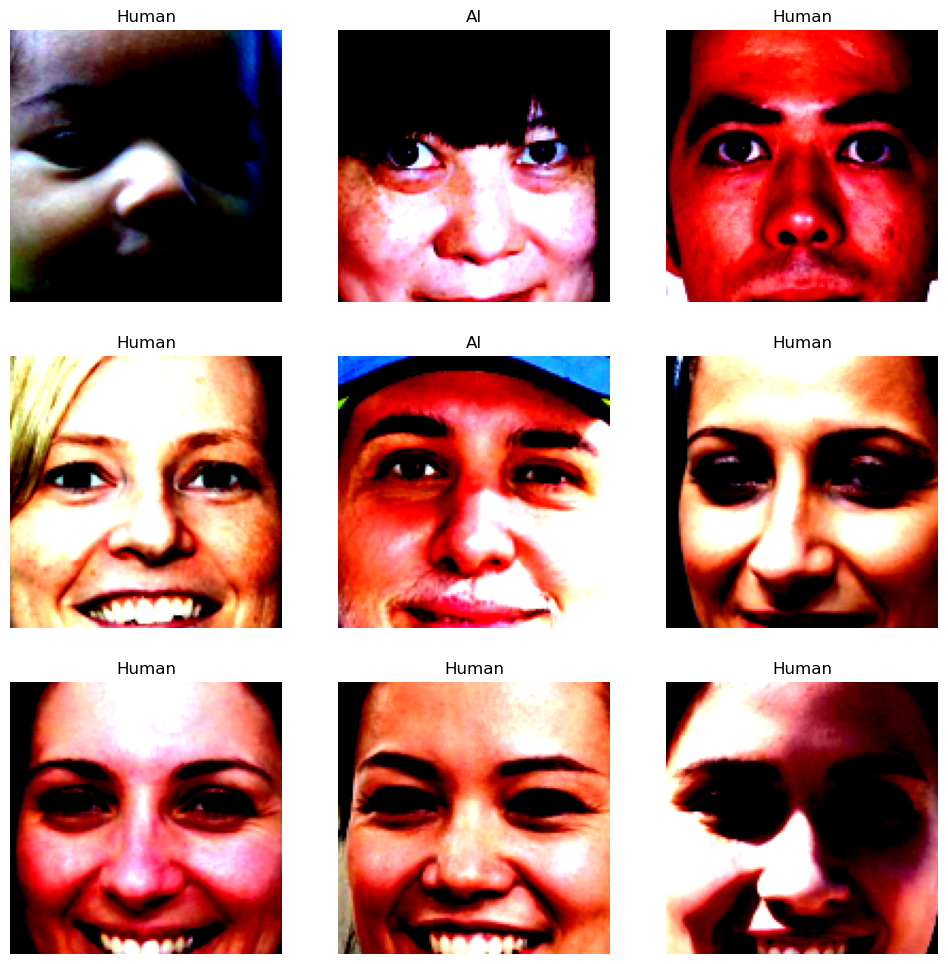

In [95]:
figure = plt.figure(figsize=(display_figure_info["width"], display_figure_info["height"]))

for i in range(1, display_figure_info["row"] * display_figure_info["column"] + 1):
    image_index = (i - 1) % len(images)
    image = images[image_index].cpu().squeeze(0).permute(1, 2, 0)
    label = prediction_labels[image_index]

    figure.add_subplot(display_figure_info["row"], display_figure_info["column"], i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(image)

plt.show()

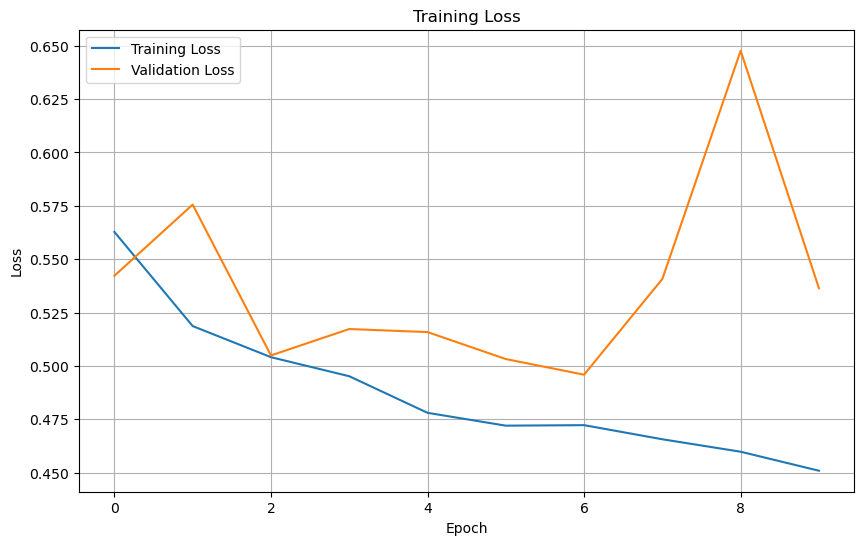

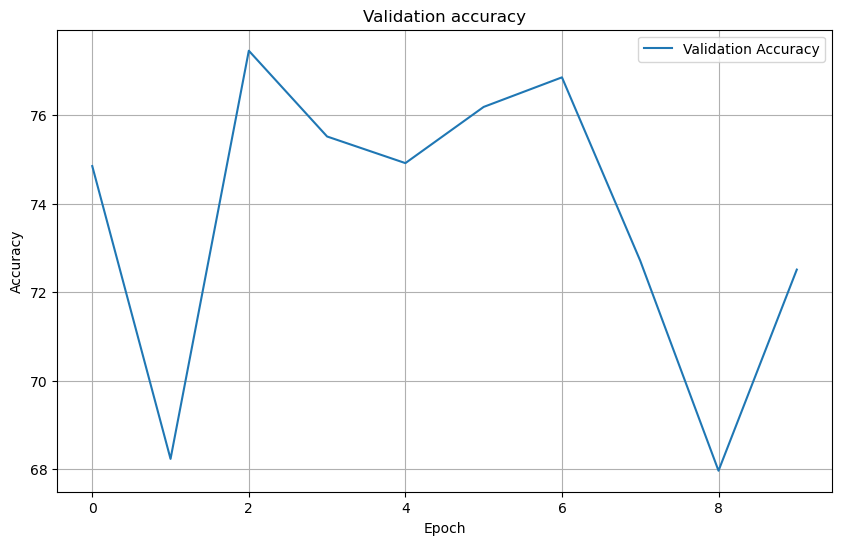

Final Training Accuracy: 76.15%


In [96]:
# Loss graph
plt.figure(figsize=(10, 6))
plt.plot(epoch_losses, label="Training Loss") # Training loss
plt.plot(val_losses, label="Validation Loss") # Validation loss
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()    
plt.legend()    
plt.grid(True)

count = 1

while (True):
    if (os.path.isfile("../../trained_models/image_faces_custom_model_" + f"{count}" + ".pth") == False):
        plt.savefig("../../src/image/graphs/image_faces_custom_model_" + f"{count - 1}" + "_training_loss.png") # Save the graph
        break
    else:
        count += 1

plt.show()

# Accuracy graph
plt.figure(figsize=(10, 6))
plt.plot(val_accuracies, label="Validation Accuracy") # Validation accuracy
plt.title("Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

count = 1

while (True):
    if (os.path.isfile("../../trained_models/image_faces_custom_model_" + f"{count}" + ".pth") == False):
        plt.savefig("../../src/image/graphs/image_faces_custom_model_" + f"{count - 1}" + "_validation_accuracy.png") # Save the graph
        break
    else:
        count += 1

plt.show()

# Calculate the accuracy for the entire training set
train_accuracy = 100 * sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)

print(f"Final Training Accuracy: {train_accuracy:.2f}%")

Classification Report:
               precision    recall  f1-score   support

       Human       0.74      0.72      0.73    126720
          AI       0.78      0.79      0.79    157300

    accuracy                           0.76    284020
   macro avg       0.76      0.76      0.76    284020
weighted avg       0.76      0.76      0.76    284020



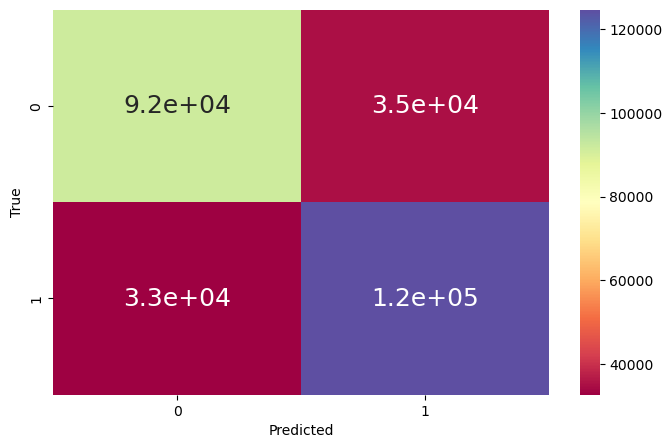

In [97]:
# Classification report
train_report = classification_report(all_labels, all_preds, target_names=[labels_map[i] for i in labels_map])

print("Classification Report:\n", train_report)

# Confusion matrix
cf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 5))
sns.heatmap(cf_matrix, annot=True, annot_kws={"size": 18}, cmap="Spectral")
plt.ylabel('True')
plt.xlabel('Predicted')

count = 1

while (True):
    if (os.path.isfile("../../trained_models/image_faces_custom_model_" + f"{count}" + ".pth") == False):
        plt.savefig("../../src/image/graphs/image_faces_custom_model_" + f"{count - 1}" + "_classification_report.png") # Save the graph
        break
    else:
        count += 1

plt.show()